
# Introduction

This project is designed to predict applicants' chances of getting approved for credit cards without affecting their credit score. People can determine whether they qualify for a credit card without hurting their credit score by using a soft inquiry to predict approval probabilities. It protects credit history and is a useful tool for people looking to learn more about their approval status.

# 0. Import necessary packages and dataset

## 0.1 Import packages

In [ ]:
%%capture
! pip install dfply
! pip install imbalanced-learn
! pip install lime

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import dfply
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


## 0.2 Import datasets

In [ ]:
%%capture
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# Install Kaggle library
! pip install kaggle

# Upload Kaggle API key
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/cs3244/'

# Install Kaggle Datasets
! kaggle datasets download -d rikdifos/credit-card-approval-prediction --force

# Unzip the new file if it doesn't exist in your workspace

if os.path.exists('credit-card-approval-prediction.zip'):
  if not (os.path.exists('credit_record.csv') and os.path.exists('application_record.csv')):
    ! unzip credit-card-approval-prediction.zip

In [ ]:
# Import Datasets
credit_record = pd.read_csv("/content/credit_record.csv", sep = ",")
application_record = pd.read_csv("/content/application_record.csv", sep = ",")

# 1. Data inspection

## credit_record.csv

In [ ]:
# Display basic information about the credit_record dataset
print("Credit Record Dataset:")
print(credit_record.info())

Credit Record Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
None


In [ ]:
print("\nFirst 5 rows of Credit Record Dataset:")
print(credit_record.head())


First 5 rows of Credit Record Dataset:
        ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C


## application_record.csv

In [ ]:
# Display basic information about the application_record dataset
print("\n\nApplication Record Dataset:")
print(application_record.info())



Application Record Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  

In [ ]:
print("\nFirst 5 rows of Application Record Dataset:")
application_record.head()


First 5 rows of Application Record Dataset:


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


# 2. Data cleaning

## 2.1 Handling duplicates

We first address and eliminate duplicates. Ideally, each client, identified by a unique ID, should possess only one corresponding record in the `application_record` dataset. This step ensures the integrity of the data and prevents any distortions in the subsequent analysis.

In [ ]:
# Check for duplicates
duplicates_application_record = application_record['ID'].duplicated().sum()

print(f"Number of duplicates in Application Record Dataset based on ID: {duplicates_application_record}")

Number of duplicates in Application Record Dataset based on ID: 47


We identified 47 instances of duplicated records in the `application_record` dataset.


To isolate the pertinent and non-redundant data, we performed an intersection operation between the `application_record` and `credit_record datasets`, utilizing the ID field as the key for comparison.

In [ ]:
# Number of Unique ID
x = application_record.nunique()['ID']
print("Number of Unique Application ID = " + str(x))

y = credit_record.nunique()['ID']
print("Number of Unique Credit ID = " + str(y))

# Get the intersection of two datasets based on 'ID' column
common_ids = set(credit_record['ID']).intersection(set(application_record['ID']))

# Display the number of common IDs
print(f"\nNumber of common IDs in both datasets: {len(common_ids)}")

# Create new datasets with common IDs
credit_record = credit_record[credit_record['ID'].isin(common_ids)]
application_record = application_record[application_record['ID'].isin(common_ids)]

Number of Unique Application ID = 438510
Number of Unique Credit ID = 45985

Number of common IDs in both datasets: 36457


In [ ]:
application_record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 434812
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null

## 2.2 Handling missing values

In [ ]:
# Check for missing values in each feature column
missing_data = application_record.isnull().sum()

# Calculate the ratio of missing data
missing_ratio = (missing_data / len(application_record)) * 100

# Create a DataFrame to display results
missing_info = pd.DataFrame({
    'Feature': missing_data.index,
    'Missing Values': missing_data.values,
    'Missing Ratio (%)': missing_ratio.values
})

# Display the DataFrame
print(missing_info)

                Feature  Missing Values  Missing Ratio (%)
0                    ID               0           0.000000
1           CODE_GENDER               0           0.000000
2          FLAG_OWN_CAR               0           0.000000
3       FLAG_OWN_REALTY               0           0.000000
4          CNT_CHILDREN               0           0.000000
5      AMT_INCOME_TOTAL               0           0.000000
6      NAME_INCOME_TYPE               0           0.000000
7   NAME_EDUCATION_TYPE               0           0.000000
8    NAME_FAMILY_STATUS               0           0.000000
9     NAME_HOUSING_TYPE               0           0.000000
10           DAYS_BIRTH               0           0.000000
11        DAYS_EMPLOYED               0           0.000000
12           FLAG_MOBIL               0           0.000000
13      FLAG_WORK_PHONE               0           0.000000
14           FLAG_PHONE               0           0.000000
15           FLAG_EMAIL               0           0.0000

Given that the `OCCUPATION_TYPE` column has a missing ratio of 31.06%, it's essential to handle these missing values appropriately. A reasonable approach could be to impute the missing values with the a new catgory called "Unknown".

In [ ]:
application_record['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

#3. Label construction

## 3.1 Label definition

Since the definition of a 'good' or 'bad' customer is not explicitly given, we must establish these classifications based on the credit repayment behavior capture in `credit_record.csv`.

In this scenario, customers with `STATUS` values denoting no delays 'C,' are considered 'good.' Conversely, customers with any other 'STATUS,' indicating delayed payments, are categorized as 'bad.' This approach allows us to form a binary target variable, `TARGET,` where '1' represents 'bad' customers and '0' represents 'good' customers. The resulting distribution of this target variable will guide our subsequent analysis and modeling efforts

In [ ]:
credit_record['TARGET'] = credit_record['STATUS'].apply(lambda x: 1 if x in ['0', '1', '2', '3', '4', '5'] else 0)
def label_customer(group):
    return 1 if group['TARGET'].sum() >= 12 else 0

# Apply the function to each group and create a new DataFrame with the results
labelled_credit_record = credit_record.groupby('ID').apply(label_customer).reset_index(name='TARGET')

In [ ]:
labelled_credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      36457 non-null  int64
 1   TARGET  36457 non-null  int64
dtypes: int64(2)
memory usage: 569.8 KB


In [ ]:
target_distribution = labelled_credit_record['TARGET'].value_counts()
target_distribution

0    27767
1     8690
Name: TARGET, dtype: int64

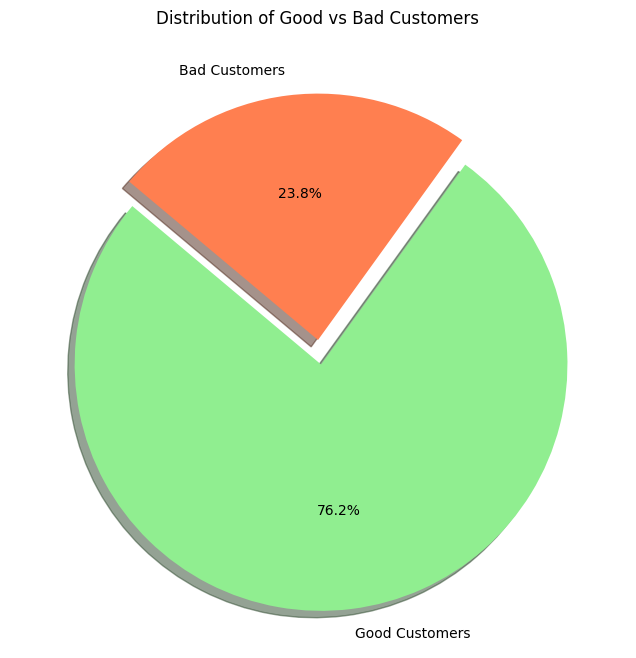

In [ ]:
# Pie chart
labels = ['Good Customers', 'Bad Customers']
colors = ['lightgreen', 'coral']
explode = (0.1, 0)  # explode the 1st slice (i.e., 'Bad Customers')

plt.figure(figsize=(8, 8))
plt.pie(target_distribution.values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Good vs Bad Customers')
plt.show()

Based on the defined criteria, The dataset consists of approximately 80% 'good' customers and 20% 'bad' customers. This distribution suggests an imbalance, with a majority of customers being classified as 'good.'

## 3.2 Merging datasets

Finally, we merge the `application_record` dataset, containing client features, with the `credit_record` dataset, which includes the target variable. As a result, the `application_record` dataset becomes a unified dataset that associates each client's application details with the corresponding credit record, facilitating a comprehensive analysis for predictive modeling.

In [ ]:
application_record = application_record.merge(labelled_credit_record, on='ID', how='inner')

In [ ]:
print("\nFirst 5 rows of Application Record Dataset:")
application_record.head()


First 5 rows of Application Record Dataset:


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Unknown,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Unknown,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [ ]:
application_record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

## 3.3 Data Formatting

CODE_GENDER

To simplify and standardize the representation of gender in the `CODE_GENDER` column, we can create a new binary column named `FLAG_IS_FEMALE` where 1 represents 'Female' and 0 represents 'Male.' This binary encoding enhances consistency and can facilitate certain machine learning algorithms.

In [ ]:
application_record['FLAG_IS_FEMALE'] = (application_record['CODE_GENDER'] == 'F').astype(int)

# Replace 'F' with 'Y' and 'M' with 'N'
application_record['CODE_GENDER'].replace({'F': 'Y', 'M': 'N'}, inplace=True)

# Drop the original 'CODE_GENDER' column
application_record.drop(['CODE_GENDER'], axis=1, inplace=True)

# Display the updated DataFrame
print(application_record[['FLAG_IS_FEMALE']].head())

   FLAG_IS_FEMALE
0               0
1               0
2               0
3               1
4               1


DAYS_BIRTH

In [ ]:
# Convert to age in years
application_record['AGE'] = -application_record['DAYS_BIRTH'] // 365
application_record.drop(['DAYS_BIRTH'], axis=1, inplace=True)

DAYS_EMPLOYED

Since the `DAYS_EMPLOYED` is recorded in such a way that positive value indicates that a person is unemployed, we first visualize the distribution of employed vs. unemployed individuals, which provides a preliminary understanding of the employment status.

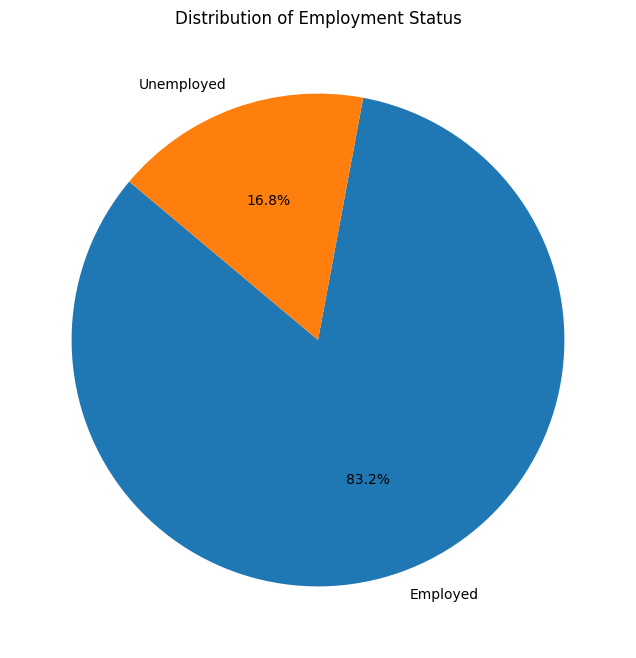

In [ ]:
# Create a binary column 'FLAG_EMPLOYED' based on whether 'YEARS_EMPLOYED' is positive
application_record['FLAG_EMPLOYED'] = (application_record['DAYS_EMPLOYED'] < 0).astype(str).replace({'True': 'Employed', 'False': 'Unemployed'})

# Visualization (Pie chart)
employment_distribution = application_record['FLAG_EMPLOYED'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(employment_distribution, labels=employment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Employment Status')
plt.show()

By setting the positive `DAYS_EMPLOYED` values to zero, we effectively "drop" the unemployed data. This allows us to focus the analysis on the majority class (employed individuals), ensuring a more balanced representation.

In [ ]:
application_record.drop(['FLAG_EMPLOYED'], axis=1, inplace=True)

application_record['DAYS_EMPLOYED'] = application_record['DAYS_EMPLOYED'].apply(lambda x: x if x <= 0 else 0)

application_record['YEARS_EMPLOYED'] = -application_record['DAYS_EMPLOYED'] // 365

application_record.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)

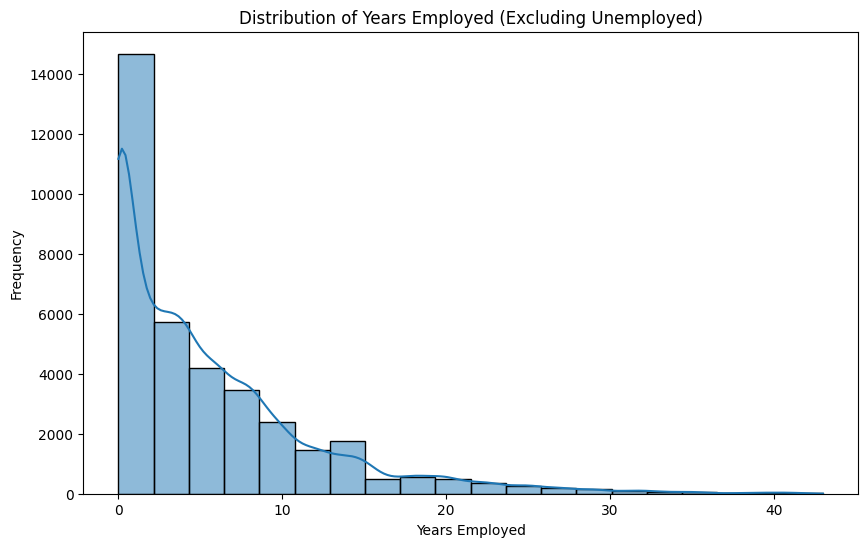

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(application_record['YEARS_EMPLOYED'], kde=True, bins=20, edgecolor='black')
plt.title('Distribution of Years Employed (Excluding Unemployed)')
plt.xlabel('Years Employed')
plt.ylabel('Frequency')
plt.show()

In [ ]:
application_record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   FLAG_OWN_CAR         36457 non-null  object 
 2   FLAG_OWN_REALTY      36457 non-null  object 
 3   CNT_CHILDREN         36457 non-null  int64  
 4   AMT_INCOME_TOTAL     36457 non-null  float64
 5   NAME_INCOME_TYPE     36457 non-null  object 
 6   NAME_EDUCATION_TYPE  36457 non-null  object 
 7   NAME_FAMILY_STATUS   36457 non-null  object 
 8   NAME_HOUSING_TYPE    36457 non-null  object 
 9   FLAG_MOBIL           36457 non-null  int64  
 10  FLAG_WORK_PHONE      36457 non-null  int64  
 11  FLAG_PHONE           36457 non-null  int64  
 12  FLAG_EMAIL           36457 non-null  int64  
 13  OCCUPATION_TYPE      36457 non-null  object 
 14  CNT_FAM_MEMBERS      36457 non-null  float64
 15  TARGET               36457 non-null 

# 4. Data splitting

Splitting the data into training and test sets is essential to evaluate the model's performance on unseen data. Typically, an 80-20 split is chosen to allocate 80% of the data for training and 20% for testing, ensuring a sufficient amount for both training and evaluation.

In [ ]:
X = application_record.drop(['ID', 'TARGET'], axis=1)
Y = application_record[['TARGET']]

# Split dataset into 20% testing, 20% validation, 60% training
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.25, random_state = 42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(21873, 17)
(7292, 17)
(7292, 17)
(21873, 1)
(7292, 1)
(7292, 1)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21873 entries, 353 to 32302
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FLAG_OWN_CAR         21873 non-null  object 
 1   FLAG_OWN_REALTY      21873 non-null  object 
 2   CNT_CHILDREN         21873 non-null  int64  
 3   AMT_INCOME_TOTAL     21873 non-null  float64
 4   NAME_INCOME_TYPE     21873 non-null  object 
 5   NAME_EDUCATION_TYPE  21873 non-null  object 
 6   NAME_FAMILY_STATUS   21873 non-null  object 
 7   NAME_HOUSING_TYPE    21873 non-null  object 
 8   FLAG_MOBIL           21873 non-null  int64  
 9   FLAG_WORK_PHONE      21873 non-null  int64  
 10  FLAG_PHONE           21873 non-null  int64  
 11  FLAG_EMAIL           21873 non-null  int64  
 12  OCCUPATION_TYPE      21873 non-null  object 
 13  CNT_FAM_MEMBERS      21873 non-null  float64
 14  FLAG_IS_FEMALE       21873 non-null  int64  
 15  AGE                  21873 non-nul

# 5. Feature Engineering

In this predictive modeling context, the columns in the `application_record.csv` dataset serve as features for predicting the target variable ('good' or 'bad' customer classification). These features encapsulate diverse applicant information, enabling the machine learning model to discern patterns and relationships that influence creditworthiness, ultimately contributing to accurate predictions.

## 5.1 Inspect and process binary features

In this section, we address binary features, which are categorical variables with two distinct values.

Next, we extract and visualize all the binary features.

In [ ]:
%%capture

# Factorize categorical columns
for col in X_train.columns:

  # check if column is object type
  # factorize the objects and FLAG columns
  if np.dtype(application_record[col]) == 'O' or col[0:4] == "FLAG":
    application_record[col] = pd.Categorical(application_record[col])

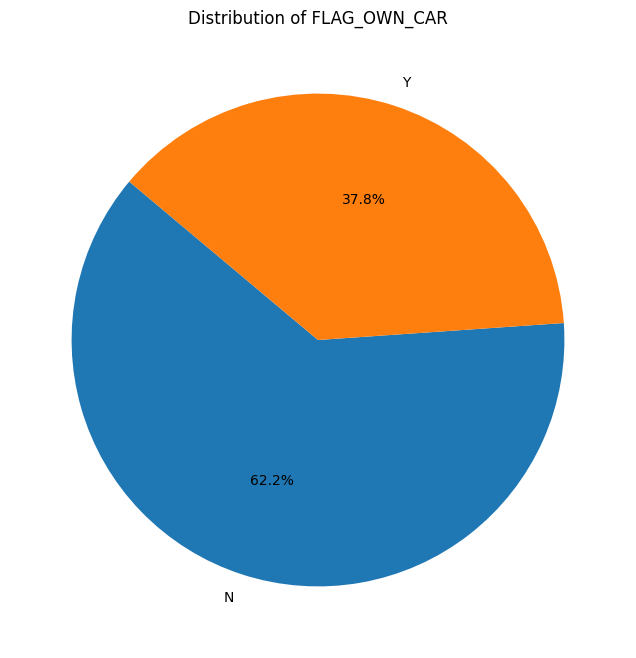

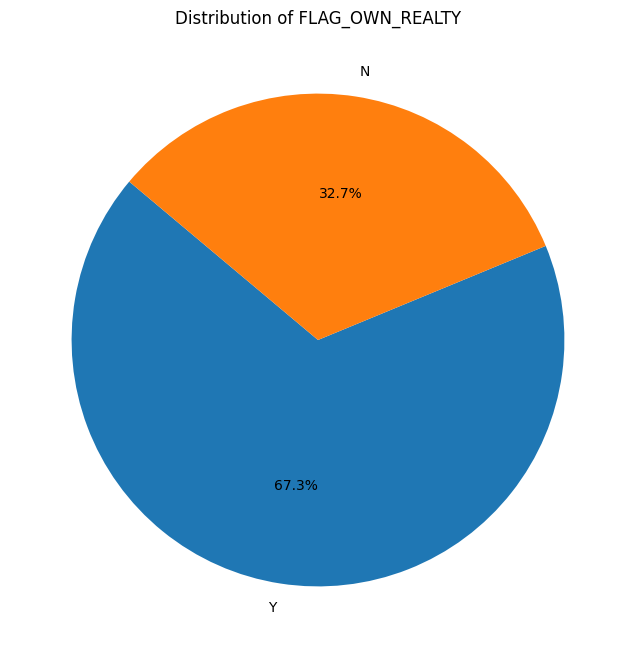

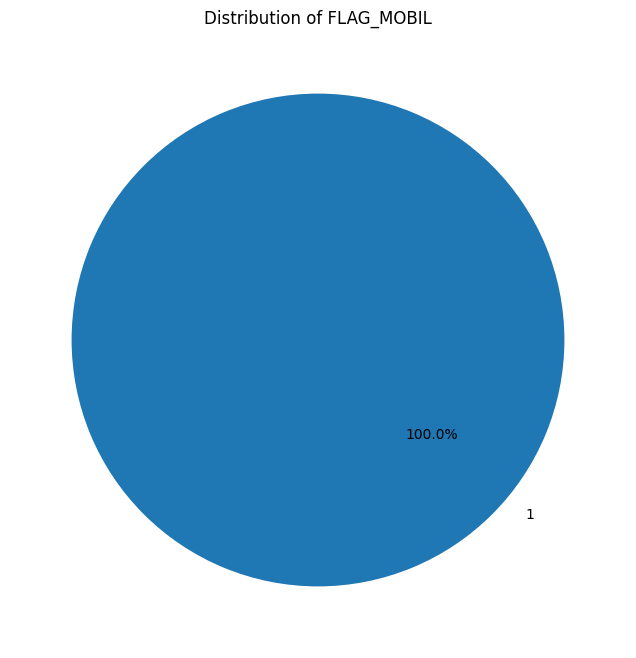

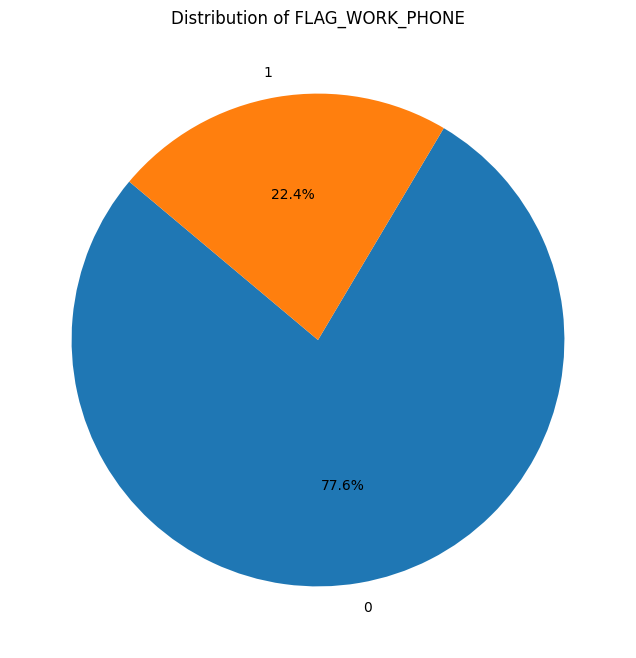

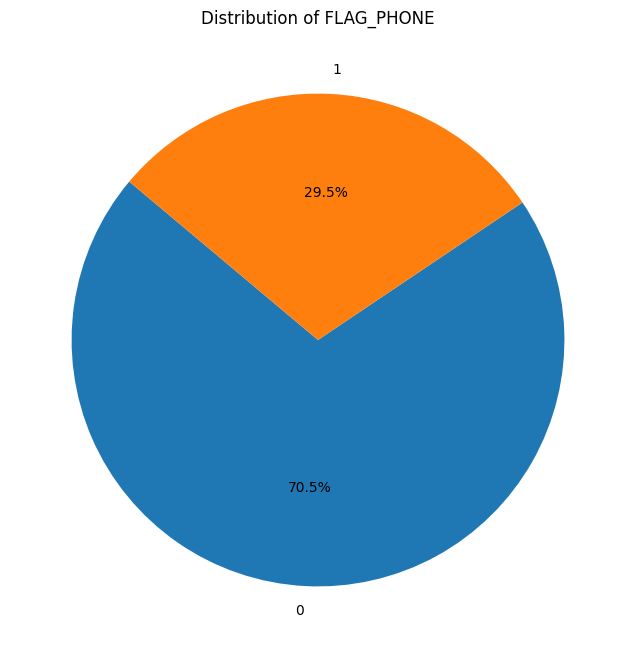

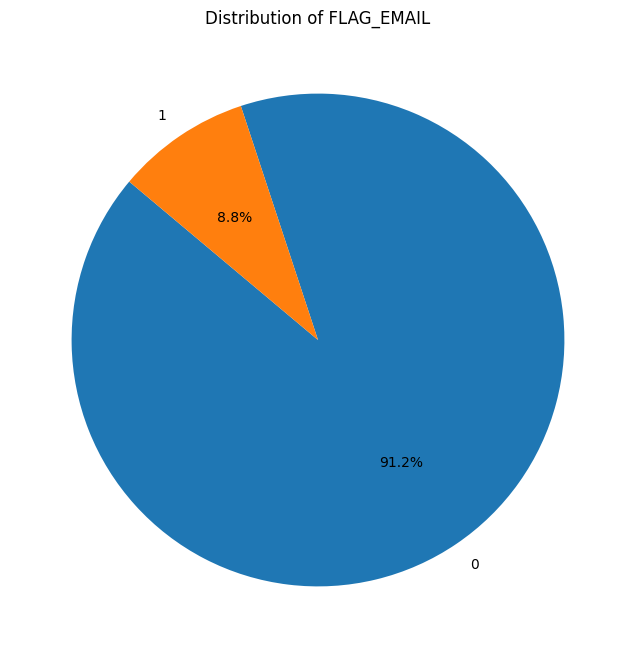

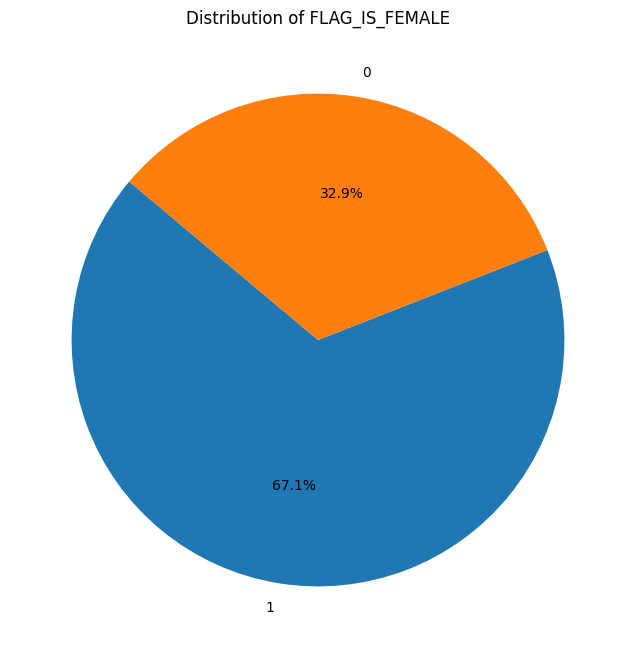

In [ ]:
# Extract columns whose names start with "FLAG"
flag_columns = [col for col in X_train.columns if col.startswith('FLAG')]

# Visualization for each FLAG column using pie chart
for col in flag_columns:
    # Count the occurrences of each value in the column
    flag_counts = X_train[col].value_counts()

    # Visualization (Pie chart)
    plt.figure(figsize=(8, 8))
    plt.pie(flag_counts, labels=flag_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of {col}')
    plt.show()

`FLAG_MOBIL` is unanimously 'Yes' (100%), so we drop this feature

In [ ]:
# Drop columns with redundant or uninformative information
X_train.drop(['FLAG_MOBIL'], inplace = True, axis='columns')
X_val.drop(['FLAG_MOBIL'], inplace = True, axis='columns')
X_test.drop(['FLAG_MOBIL'], inplace = True, axis='columns')

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21873 entries, 353 to 32302
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FLAG_OWN_CAR         21873 non-null  object 
 1   FLAG_OWN_REALTY      21873 non-null  object 
 2   CNT_CHILDREN         21873 non-null  int64  
 3   AMT_INCOME_TOTAL     21873 non-null  float64
 4   NAME_INCOME_TYPE     21873 non-null  object 
 5   NAME_EDUCATION_TYPE  21873 non-null  object 
 6   NAME_FAMILY_STATUS   21873 non-null  object 
 7   NAME_HOUSING_TYPE    21873 non-null  object 
 8   FLAG_WORK_PHONE      21873 non-null  int64  
 9   FLAG_PHONE           21873 non-null  int64  
 10  FLAG_EMAIL           21873 non-null  int64  
 11  OCCUPATION_TYPE      21873 non-null  object 
 12  CNT_FAM_MEMBERS      21873 non-null  float64
 13  FLAG_IS_FEMALE       21873 non-null  int64  
 14  AGE                  21873 non-null  int64  
 15  YEARS_EMPLOYED       21873 non-nul

## 5.2 Feature correlation plot

<ipython-input-29-71e250d9132a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5)


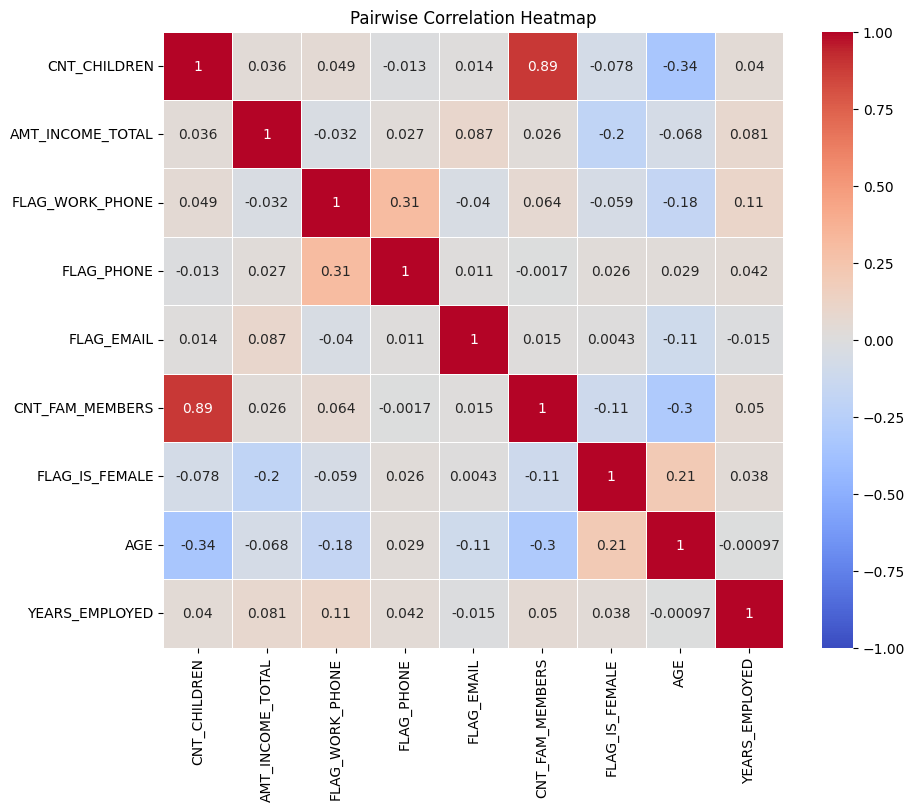

In [ ]:
# pairwise correlation plot
plt.figure(figsize=(10,8))  # Set figure size for better visualization
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5)
plt.title("Pairwise Correlation Heatmap")
plt.show()

We observed that `CNT_FAM_MEMBERS` and `CNT_CHILDREN` are highly correlated with a coefficient of 0.89. Thus we can drop one of them. We decide to drop `CNT_CHILDREN` since the number of children is a subset of family members

In [ ]:
# Drop the original 'CNT_CHILDREN' column
X_train.drop("CNT_CHILDREN", inplace = True, axis='columns')
X_val.drop("CNT_CHILDREN", inplace = True, axis='columns')
X_test.drop("CNT_CHILDREN", inplace = True, axis='columns')

## 5.3 Inspect and process categorical features

In this section, the focus is on processing categorical features, which represent variables with discrete and unordered values.

### NAME_INCOME_TYPE

NAME_INCOME_TYPE: 5 categories


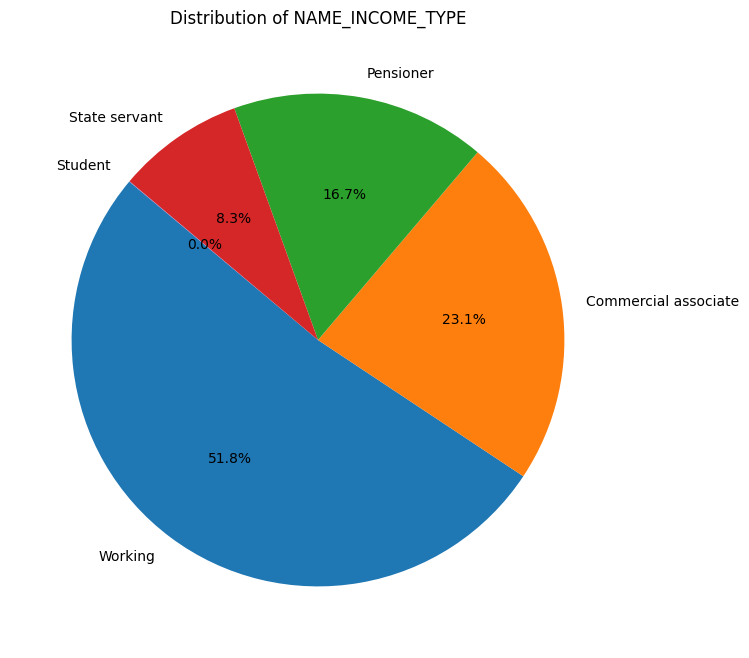

In [ ]:
# NAME_INCOME_TYPE
col = 'NAME_INCOME_TYPE'
num_categories = X_train[col].nunique()
print(f"{col}: {num_categories} categories")

# Visualization (Pie chart)
category_distribution = X_train[col].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(category_distribution, labels=category_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Distribution of {col}')
plt.show()

### NAME_EDUCATION_TYPE

NAME_EDUCATION_TYPE: 5 categories


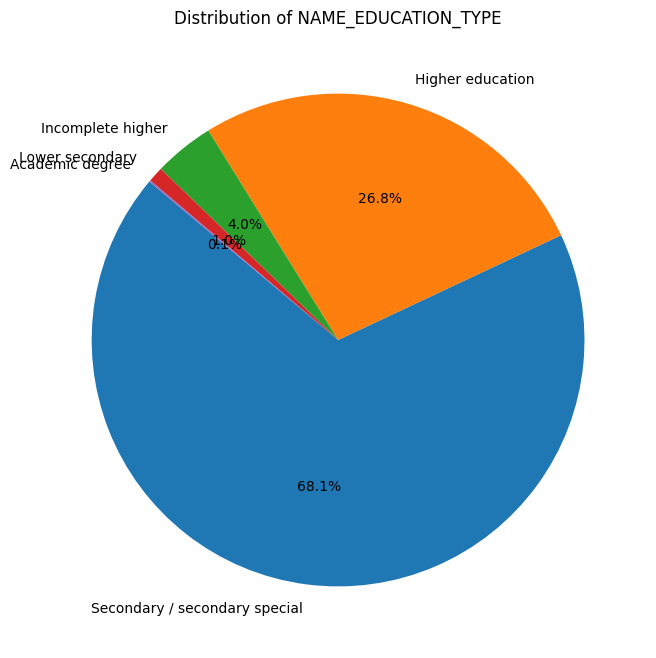

In [ ]:
# NAME_EDUCATION_TYPE
col = 'NAME_EDUCATION_TYPE'
num_categories = X_train[col].nunique()
print(f"{col}: {num_categories} categories")

# Visualization (Pie chart)
category_distribution = X_train[col].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(category_distribution, labels=category_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Distribution of {col}')
plt.show()

The distribution of the `NAME_EDUCATION_TYPE` is highly imbalanced, with the majority of individuals holding "Secondary / secondary special" education (67.8%), followed by "Higher education" (27.2%), "Incomplete higher" (3.8%), "Lower secondary" (1.0%), and "Academic degree" (0.1%).

### NAME_FAMILY_STATUS

NAME_FAMILY_STATUS: 5 categories


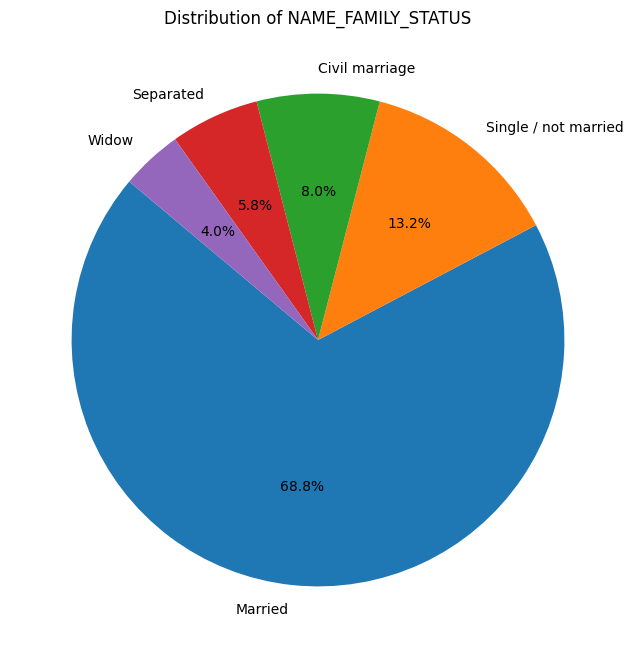

In [ ]:
# NAME_FAMILY_STATUS
col = 'NAME_FAMILY_STATUS'
num_categories = X_train[col].nunique()
print(f"{col}: {num_categories} categories")

# Visualization (Pie chart)
category_distribution = X_train[col].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(category_distribution, labels=category_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Distribution of {col}')
plt.show()

### NAME_HOUSING_TYPE

NAME_HOUSING_TYPE: 6 categories


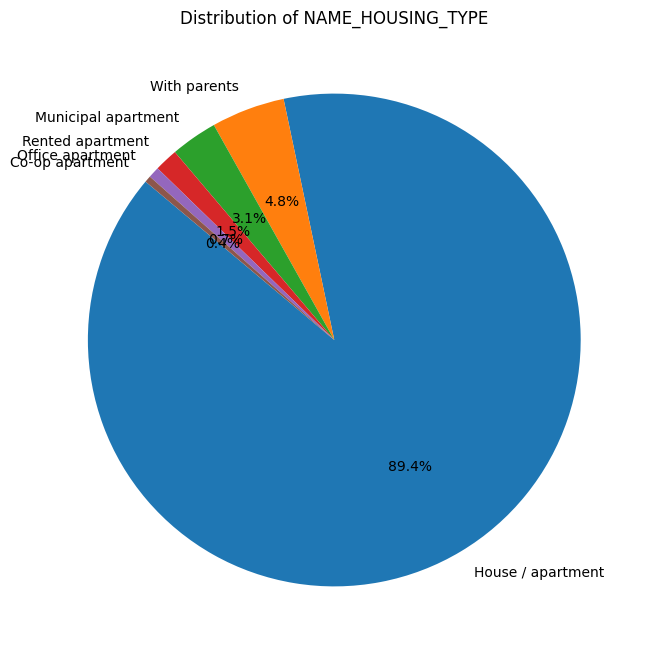

In [ ]:
# NAME_HOUSING_TYPE
col = 'NAME_HOUSING_TYPE'
num_categories = X_train[col].nunique()
print(f"{col}: {num_categories} categories")

# Visualization (Pie chart)
category_distribution = X_train[col].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(category_distribution, labels=category_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Distribution of {col}')
plt.show()

### OCCUPATION_TYPE

OCCUPATION_TYPE: 19 categories
Columns in 'Other' category:
['Waiters/barmen staff', 'Cleaning staff', 'Cooking staff', 'High skill tech staff', 'Private service staff', 'Accountants', 'Security staff', 'Secretaries', 'Medicine staff', 'Low-skill Laborers', 'HR staff', 'Realty agents', 'IT staff']
13


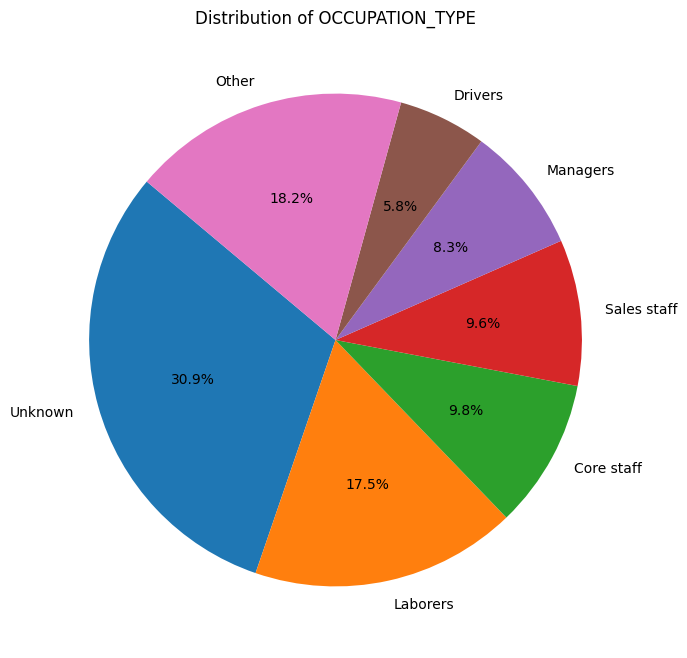

In [ ]:
# OCCUPATION_TYPE
col = 'OCCUPATION_TYPE'
num_categories = X_train[col].nunique()
print(f"{col}: {num_categories} categories")

# Grouping small categories (< 5%) into 'Other'
threshold = 1000
category_distribution = X_train[col].value_counts()
small_categories = category_distribution[category_distribution < threshold]
other_count = small_categories.sum()
significant_categories = category_distribution[category_distribution >= threshold]
significant_categories['Other'] = other_count

# Visualization (Pie Chart with 'Other' category)
plt.figure(figsize=(8, 8))
plt.pie(significant_categories, labels=significant_categories.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Distribution of {col}')

# Extracting names of columns in 'Other' category
columns_in_other = []

if 'Other' in significant_categories.index:
    other_data = X_train[X_train[col].isin(small_categories.index)]
    columns_in_other = other_data[col].unique().tolist()

print("Columns in 'Other' category:")
print(columns_in_other)
print(len(columns_in_other))

plt.show()

From pie-chart, we see that OCCUPATION_TYPE has high cardinality, meaning it has many categories, while also having a large percentage of missing values. Thus this feature is not very informative and will complicate the model ,so we drop it.

In [ ]:
# Drop the 'OCCUPATION_TYPE' column
X_train.drop(['OCCUPATION_TYPE'], axis=1, inplace=True)
X_test.drop(['OCCUPATION_TYPE'], axis=1, inplace=True)
X_val.drop(['OCCUPATION_TYPE'], axis=1, inplace=True)

## 5.4 Inspect and process numerical features

In this section, the focus is on processing numerical features, which represent variables with continuous values.

### CNT_FAM_MEMBERS

count    21873.000000
mean         2.198007
std          0.909378
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: CNT_FAM_MEMBERS, dtype: float64


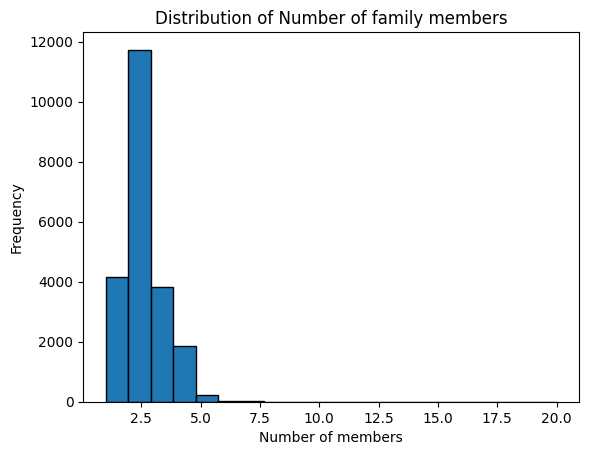

In [ ]:
children_stats = X_train['CNT_FAM_MEMBERS'].describe()
print(children_stats)

# Visualization
X_train['CNT_FAM_MEMBERS'].hist(bins=20, edgecolor='black', grid=False)
plt.title('Distribution of Number of family members')
plt.xlabel('Number of members')
plt.ylabel('Frequency')
plt.show()

### AMT_INCOME_TOTAL

count    2.187300e+04
mean     1.866774e+05
std      1.008926e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: AMT_INCOME_TOTAL, dtype: float64


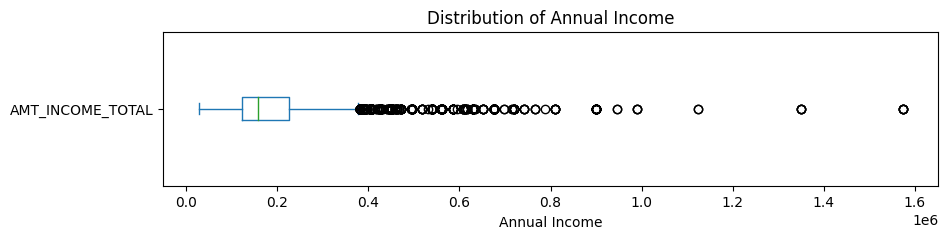

In [ ]:
income_stats = X_train['AMT_INCOME_TOTAL'].describe()
print(income_stats)

# Visualization
X_train['AMT_INCOME_TOTAL'].plot(kind='box', vert=False, figsize=(10, 2))
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income')
plt.show()

The `AMT_INCOME_TOTAL` feature indicates that the majority of applicants have an annual income between 121,500 and 225,000, with a mean income of 186,685. However, there is a notable income disparity, as the maximum income reaches 1,575,000.

### AGE

count    21873.000000
mean        43.216980
std         11.508938
min         21.000000
25%         34.000000
50%         42.000000
75%         53.000000
max         68.000000
Name: AGE, dtype: float64


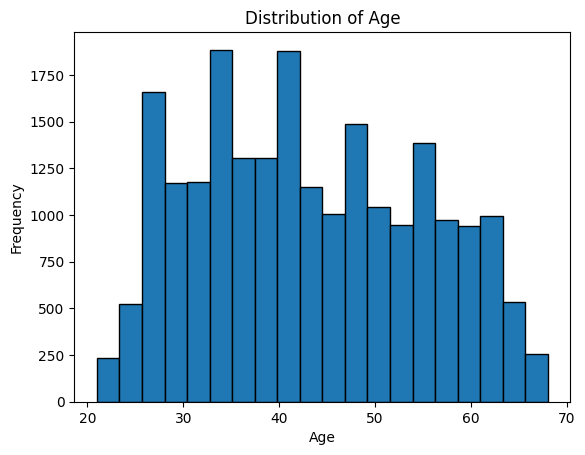

In [ ]:
age_stats = X_train['AGE'].describe()
print(age_stats)

# Visualization
X_train['AGE'].hist(bins=20, edgecolor='black', grid=False)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The `AGE` feature provides insights into the age distribution of applicants, ranging from 20 to 68 years. The mean age is approximately 43.26, with a standard deviation of 11.51.

## Renaming

Below are the remaining columns after initial processing:

In [ ]:
print(X_train.columns)

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'FLAG_IS_FEMALE', 'AGE', 'YEARS_EMPLOYED'],
      dtype='object')


We rename the columns to make them more distinguishable.

In [ ]:
rename_map = {
    'NAME_INCOME_TYPE': 'CAT_INCOME_TYPE',
    'NAME_EDUCATION_TYPE': 'CAT_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS': 'CAT_FAMILY_STATUS',
    'NAME_HOUSING_TYPE': 'CAT_HOUSING_TYPE',
    'AMT_INCOME_TOTAL': 'NUM_INCOME_TOTAL',
    'CNT_FAM_MEMBERS': 'NUM_FAM_MEMBERS',
    'AGE': 'NUM_AGE',
    'YEARS_EMPLOYED': 'NUM_YEARS_EMPLOYED'
}
X_train.rename(columns=rename_map, inplace=True)
X_test.rename(columns=rename_map, inplace=True)
X_val.rename(columns=rename_map, inplace=True)

# Display the DataFrame with the renamed columns
print(X_train.columns)

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NUM_INCOME_TOTAL',
       'CAT_INCOME_TYPE', 'CAT_EDUCATION_TYPE', 'CAT_FAMILY_STATUS',
       'CAT_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'NUM_FAM_MEMBERS', 'FLAG_IS_FEMALE', 'NUM_AGE', 'NUM_YEARS_EMPLOYED'],
      dtype='object')


## 5.5 Feature Encoding

### 5.5.1 Binary features

For binary features, label encoding is commonly used, where the categories are assigned numerical values (usually 0 and 1 for binary features).

In [ ]:
from sklearn.preprocessing import LabelEncoder

binary_columns = [col for col in X_train.columns if col.startswith('FLAG')]

label_encoder = LabelEncoder()
for col in binary_columns:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.fit_transform(X_test[col])
    X_val[col] = label_encoder.fit_transform(X_val[col])


In [ ]:
X_train.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,NUM_INCOME_TOTAL,CAT_INCOME_TYPE,CAT_EDUCATION_TYPE,CAT_FAMILY_STATUS,CAT_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,NUM_FAM_MEMBERS,FLAG_IS_FEMALE,NUM_AGE,NUM_YEARS_EMPLOYED
353,0,0,74250.0,Working,Higher education,Separated,Municipal apartment,0,1,0,1.0,1,52,14
31661,0,1,157500.0,State servant,Secondary / secondary special,Single / not married,House / apartment,0,0,0,2.0,1,34,3
152,0,1,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,2.0,1,61,0
934,1,0,157500.0,Working,Secondary / secondary special,Married,Office apartment,0,0,1,4.0,0,40,6
22245,1,1,225000.0,Working,Secondary / secondary special,Married,House / apartment,0,1,0,2.0,0,44,0


### 5.5.2 Numerical features

For numerical features, it's common to apply scaling to ensure that all numerical features have a similar scale.

Min-Max Scaling: scales the values to a specific range, typically [0, 1]. It's suitable when the distribution of your numerical features is not necessarily Gaussian and when you want to preserve the relative relationships between data points.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

numerical_columns = [col for col in X_train.columns if col.startswith('NUM')]

minmax_scaler = MinMaxScaler()
X_train[numerical_columns] = minmax_scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = minmax_scaler.fit_transform(X_test[numerical_columns])
X_val[numerical_columns] = minmax_scaler.fit_transform(X_val[numerical_columns])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21873 entries, 353 to 32302
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FLAG_OWN_CAR        21873 non-null  int64  
 1   FLAG_OWN_REALTY     21873 non-null  int64  
 2   NUM_INCOME_TOTAL    21873 non-null  float64
 3   CAT_INCOME_TYPE     21873 non-null  object 
 4   CAT_EDUCATION_TYPE  21873 non-null  object 
 5   CAT_FAMILY_STATUS   21873 non-null  object 
 6   CAT_HOUSING_TYPE    21873 non-null  object 
 7   FLAG_WORK_PHONE     21873 non-null  int64  
 8   FLAG_PHONE          21873 non-null  int64  
 9   FLAG_EMAIL          21873 non-null  int64  
 10  NUM_FAM_MEMBERS     21873 non-null  float64
 11  FLAG_IS_FEMALE      21873 non-null  int64  
 12  NUM_AGE             21873 non-null  float64
 13  NUM_YEARS_EMPLOYED  21873 non-null  float64
dtypes: float64(4), int64(6), object(4)
memory usage: 2.5+ MB


In [ ]:
X_train.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,NUM_INCOME_TOTAL,CAT_INCOME_TYPE,CAT_EDUCATION_TYPE,CAT_FAMILY_STATUS,CAT_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,NUM_FAM_MEMBERS,FLAG_IS_FEMALE,NUM_AGE,NUM_YEARS_EMPLOYED
353,0,0,0.030523,Working,Higher education,Separated,Municipal apartment,0,1,0,0.000000,1,0.659574,0.325581
31661,0,1,0.084302,State servant,Secondary / secondary special,Single / not married,House / apartment,0,0,0,0.052632,1,0.276596,0.069767
152,0,1,0.055233,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,0.052632,1,0.851064,0.000000
934,1,0,0.084302,Working,Secondary / secondary special,Married,Office apartment,0,0,1,0.157895,0,0.404255,0.139535
22245,1,1,0.127907,Working,Secondary / secondary special,Married,House / apartment,0,1,0,0.052632,0,0.489362,0.000000


# 6. Data preprocessing

In this section, we tackle three primary data challenges: assessing linear separability, addressing the curse of dimensionality, and managing imbalanced data. We examine the presence of these issues and implement strategies to mitigate them, enhancing the overall effectiveness of our modeling process.

## 4.1 Oversampling

The imbalanced data problem occurs when one class significantly outnumbers the others in a dataset.

As discussed in Section 2, our labeled dataset demonstrates this imbalance, with approximately 80% of customers categorized as "Good" and 20% as "Bad." Given that "Good" is the majority class and significantly outnumbering the minority, employing undersampling would result in substantial data loss. Therefore, an oversampling technique is recommended for the minority class to balance the dataset without sacrificing data.

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21873 entries, 353 to 32302
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FLAG_OWN_CAR        21873 non-null  int64  
 1   FLAG_OWN_REALTY     21873 non-null  int64  
 2   NUM_INCOME_TOTAL    21873 non-null  float64
 3   CAT_INCOME_TYPE     21873 non-null  object 
 4   CAT_EDUCATION_TYPE  21873 non-null  object 
 5   CAT_FAMILY_STATUS   21873 non-null  object 
 6   CAT_HOUSING_TYPE    21873 non-null  object 
 7   FLAG_WORK_PHONE     21873 non-null  int64  
 8   FLAG_PHONE          21873 non-null  int64  
 9   FLAG_EMAIL          21873 non-null  int64  
 10  NUM_FAM_MEMBERS     21873 non-null  float64
 11  FLAG_IS_FEMALE      21873 non-null  int64  
 12  NUM_AGE             21873 non-null  float64
 13  NUM_YEARS_EMPLOYED  21873 non-null  float64
dtypes: float64(4), int64(6), object(4)
memory usage: 2.5+ MB


In [ ]:
from imblearn.over_sampling import SMOTENC

categorical_features = [0, 1, 3, 4, 5, 6, 7, 8, 9, 11]

# Instantiate SMOTENC. Provide the correct columns as categorical.
smote_nc = SMOTENC(sampling_strategy='auto', categorical_features=categorical_features, random_state=42, k_neighbors=5)

# Fit on training data
X_train_resampled, Y_train_resampled = smote_nc.fit_resample(X_train, Y_train)

In [ ]:
# Check the distribution of the target variable after SMOTENC
print(Y_train['TARGET'].value_counts())
print(Y_train_resampled['TARGET'].value_counts())

0    16682
1     5191
Name: TARGET, dtype: int64
0    16682
1    16682
Name: TARGET, dtype: int64


In [ ]:
X_train_resampled.head(10)

,FLAG_OWN_CAR,FLAG_OWN_REALTY,NUM_INCOME_TOTAL,CAT_INCOME_TYPE,CAT_EDUCATION_TYPE,CAT_FAMILY_STATUS,CAT_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,NUM_FAM_MEMBERS,FLAG_IS_FEMALE,NUM_AGE,NUM_YEARS_EMPLOYED
0,0,0,0.030523,Working,Higher education,Separated,Municipal apartment,0,1,0,0.000000,1,0.659574,0.325581
1,0,1,0.084302,State servant,Secondary / secondary special,Single / not married,House / apartment,0,0,0,0.052632,1,0.276596,0.069767
2,0,1,0.055233,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,0.052632,1,0.851064,0.000000
3,1,0,0.084302,Working,Secondary / secondary special,Married,Office apartment,0,0,1,0.157895,0,0.404255,0.139535
4,1,1,0.127907,Working,Secondary / secondary special,Married,House / apartment,0,1,0,0.052632,0,0.489362,0.000000
5,1,0,0.133721,Working,Secondary / secondary special,Married,House / apartment,1,1,0,0.052632,0,0.680851,0.046512
6,0,0,0.046512,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,0,0.000000,1,0.489362,0.023256
7,0,1,0.174419,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,0,0,0,0.000000,1,0.446809,0.186047
8,0,1,0.113372,Working,Secondary / secondary special,Separated,House / apartment,0,0,0,0.000000,1,0.361702,0.046512
9,0,1,0.069767,Working,Secondary / secondary special,Married,House / apartment,0,0,0,0.052632,1,0.595745,0.325581


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

#Instantiate undersampler
undersampler = RandomUnderSampler(random_state=42)

#Fit on training data
X_train_undersampled, Y_train_undersampled = undersampler.fit_resample(X_train, Y_train)

In [ ]:
# Check the distribution of the target variable after Random Undersampler
print(Y_train['TARGET'].value_counts())
print(Y_train_undersampled['TARGET'].value_counts())

0    16682
1     5191
Name: TARGET, dtype: int64
0    5191
1    5191
Name: TARGET, dtype: int64


### Categorical features Encoding

**We need to oversample before one-hot encoding**

For categorical features, one-hot encoding is a common technique. One-hot encoding transforms categorical variables into binary vectors, where each category becomes a separate column with binary values (0 or 1).

In [ ]:
categorical_columns = [col for col in X_train_resampled.columns if col.startswith('CAT')]

# One-hot encode categorical columns
X_train_resampled = pd.get_dummies(X_train_resampled, columns=categorical_columns)

X_train = pd.get_dummies(X_train, columns=categorical_columns)
X_test = pd.get_dummies(X_test, columns=categorical_columns)
X_val = pd.get_dummies(X_val, columns=categorical_columns)

In [ ]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33364 entries, 0 to 33363
Data columns (total 31 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   FLAG_OWN_CAR                                      33364 non-null  int64  
 1   FLAG_OWN_REALTY                                   33364 non-null  int64  
 2   NUM_INCOME_TOTAL                                  33364 non-null  float64
 3   FLAG_WORK_PHONE                                   33364 non-null  int64  
 4   FLAG_PHONE                                        33364 non-null  int64  
 5   FLAG_EMAIL                                        33364 non-null  int64  
 6   NUM_FAM_MEMBERS                                   33364 non-null  float64
 7   FLAG_IS_FEMALE                                    33364 non-null  int64  
 8   NUM_AGE                                           33364 non-null  float64
 9   NUM_YEARS_EMPLOYE

In [ ]:
X_train_resampled.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,NUM_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,NUM_FAM_MEMBERS,FLAG_IS_FEMALE,NUM_AGE,NUM_YEARS_EMPLOYED,...,CAT_FAMILY_STATUS_Married,CAT_FAMILY_STATUS_Separated,CAT_FAMILY_STATUS_Single / not married,CAT_FAMILY_STATUS_Widow,CAT_HOUSING_TYPE_Co-op apartment,CAT_HOUSING_TYPE_House / apartment,CAT_HOUSING_TYPE_Municipal apartment,CAT_HOUSING_TYPE_Office apartment,CAT_HOUSING_TYPE_Rented apartment,CAT_HOUSING_TYPE_With parents
0,0,0,0.030523,0,1,0,0.000000,1,0.659574,0.325581,...,0,1,0,0,0,0,1,0,0,0
1,0,1,0.084302,0,0,0,0.052632,1,0.276596,0.069767,...,0,0,1,0,0,1,0,0,0,0
2,0,1,0.055233,0,0,0,0.052632,1,0.851064,0.000000,...,1,0,0,0,0,1,0,0,0,0
3,1,0,0.084302,0,0,1,0.157895,0,0.404255,0.139535,...,1,0,0,0,0,0,0,1,0,0
4,1,1,0.127907,0,1,0,0.052632,0,0.489362,0.000000,...,1,0,0,0,0,1,0,0,0,0


## 4.2 Linear separability

Linear separability refers to the situation where classes in a dataset can be perfectly separated by a straight line. It becomes problematic when real-world data is not distinctly divided, leading to challenges in accurately classifying instances. This issue typically arises when classes overlap or exhibit complex, non-linear relationships.

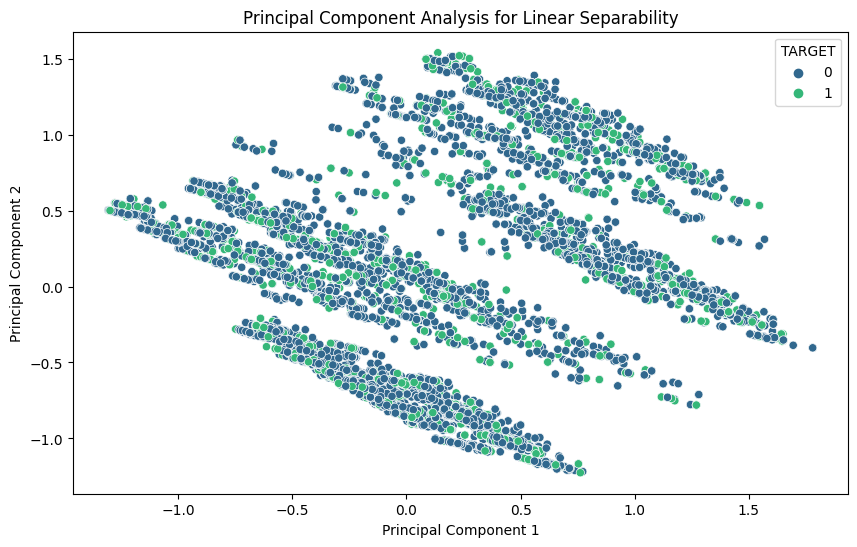

In [ ]:
from sklearn.decomposition import PCA

# Assume X is the feature matrix (exclude 'ID' and 'TARGET' columns)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Visualize the data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=Y_train['TARGET'], palette='viridis')
plt.title('Principal Component Analysis for Linear Separability')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='TARGET', loc='upper right')
plt.show()

From the PCA plot, we observe that the data for two target groups are clustered together into several distinct groups, suggesting that there may be nonlinear relationships or interactions among the features rather than a clear linear separation. This implies that linear models may face challenges in capturing the complexities of the dataset, and nonlinear models might be more appropriate for accurate predictions.

# 7. Model training

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.svm import SVC

## 7.1 Logistic Regression

In [ ]:
C_values = [0.001, 0.01, 0.1, 1]

# Create a parameter grid for GridSearchCV
param_grid = {'C': C_values}

# Initialize a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Perform a grid search with cross-validation to find the best C value
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_val, Y_val.values.ravel())

# Get the best C value
best_C = grid_search.best_params_['C']

print(best_C)

0.001


In [ ]:
logistic_model = LogisticRegression(C = best_C, max_iter=1000)
logistic_model.fit(X_train_resampled, Y_train_resampled.values.ravel())

LogisticRegression(C=0.001, max_iter=1000)

In [ ]:
lg_train_predictions = logistic_model.predict(X_train_resampled)
lg_train_accuracy = accuracy_score(Y_train_resampled.values.ravel(), lg_train_predictions)
print('Logistic regression accuracy for train set: %f' % lg_train_accuracy)

lg_test_predictions = logistic_model.predict(X_test)
lg_test_accuracy = accuracy_score(Y_test.values.ravel(), lg_test_predictions)

Logistic regression accuracy for train set: 0.562103


In [ ]:
class_report = classification_report(Y_test.values.ravel(), lg_test_predictions)
print(f"Classification Report:\n{class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.50      0.61      5551
           1       0.26      0.55      0.35      1741

    accuracy                           0.51      7292
   macro avg       0.52      0.52      0.48      7292
weighted avg       0.65      0.51      0.55      7292



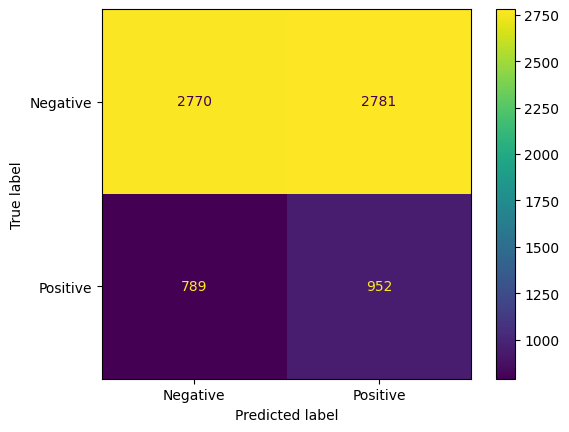

In [ ]:
conf_matrix = confusion_matrix(Y_test.values.ravel(), lg_test_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Negative", "Positive"])
cm_display.plot(values_format='d')
plt.show()

In [ ]:
score = roc_auc_score(Y_test, lg_test_predictions)
score

0.5229106822217998

ROC curve

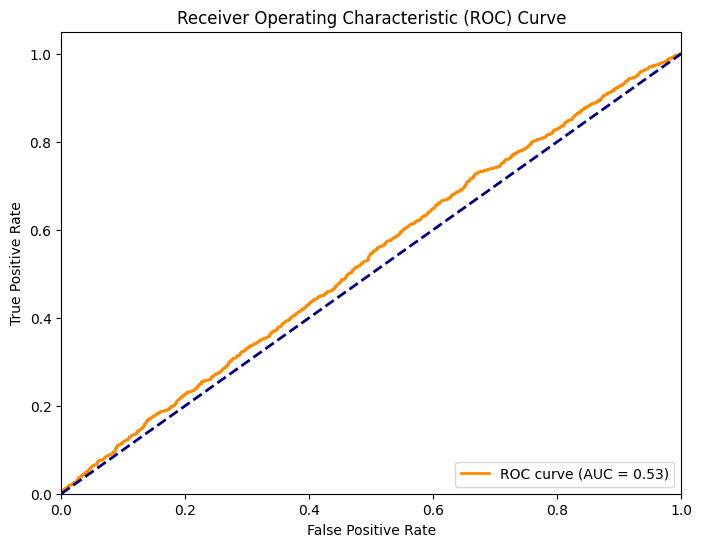

In [ ]:


# Get predicted probabilities for the positive class (class '1')
lg_test_probs = logistic_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, lg_test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## 7.2 Decision Tree and Random Forest

### 7.2.1 Decision Tree

Parameter Tuning

In [ ]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [None, 1, 5, 10],
    'min_samples_split': [20, 50],
    'min_samples_leaf': [2, 10, 25, 50],
    'max_features': ['sqrt', 'log2', None]
}

# Create a base model
dt = DecisionTreeClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_val, Y_val)

# Get the best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_parameters)
print("Best cross-validated score: ", best_score)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 50, 'min_samples_split': 20}
Best cross-validated score:  0.7589139262380702


Train Model

In [ ]:
# Train a Decision Tree Classifier
decision_tree = DecisionTreeClassifier(max_depth = None, max_features = 'log2', min_samples_leaf = 50, min_samples_split = 20, random_state=42)
decision_tree.fit(X_train_resampled, Y_train_resampled.values.ravel())

DecisionTreeClassifier(max_features='log2', min_samples_leaf=50,
                       min_samples_split=20, random_state=42)

Evalutate Model

In [ ]:
dt_train_predictions = decision_tree.predict(X_train_resampled)
dt_train_accuracy = accuracy_score(Y_train_resampled.values.ravel(), dt_train_predictions)
print('Decision Tree accuracy for train set: %f' % dt_train_accuracy)

dt_test_predictions = decision_tree.predict(X_test)
dt_test_accuracy = accuracy_score(Y_test.values.ravel(), dt_test_predictions)
print('Decision Tree accuracy for test set: %f' % dt_test_accuracy)

Decision Tree accuracy for train set: 0.635625
Decision Tree accuracy for test set: 0.519885


In [ ]:
class_report = classification_report(Y_test.values.ravel(), dt_test_predictions)
print(f"Classification Report:\n{class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.50      0.61      5551
           1       0.27      0.58      0.37      1741

    accuracy                           0.52      7292
   macro avg       0.53      0.54      0.49      7292
weighted avg       0.67      0.52      0.55      7292



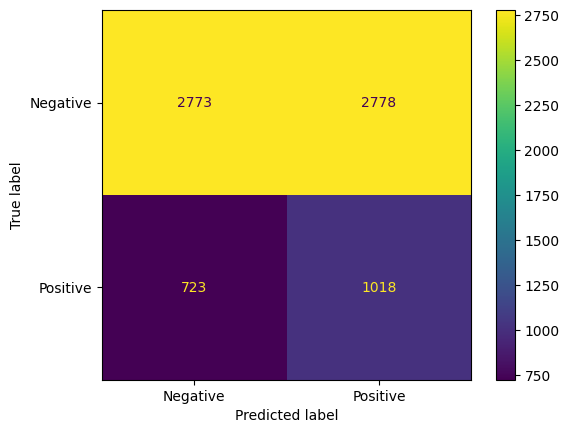

In [ ]:
conf_matrix = confusion_matrix(Y_test.values.ravel(), dt_test_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Negative", "Positive"])
cm_display.plot(values_format='d')
plt.show()

In [ ]:
score = roc_auc_score(Y_test, dt_test_predictions)
score

0.5421355275829339

### 7.2.2 Random Forest

Train Model

In [ ]:
random_forest = RandomForestClassifier(random_state = 42)
random_forest.fit(X_train_resampled, Y_train_resampled.values.ravel())

RandomForestClassifier(random_state=42)

Evaluate Model

In [ ]:
rf_train_predictions = random_forest.predict(X_train_resampled)
rf_train_accuracy = accuracy_score(Y_train_resampled.values.ravel(), rf_train_predictions)
print('Random Forest accuracy for train set: %f' % rf_train_accuracy)

rf_test_predictions = random_forest.predict(X_test)
rf_test_accuracy = accuracy_score(Y_test.values.ravel(), rf_test_predictions)
print('Random Forest accuracy for test set: %f' % rf_test_accuracy)

Random Forest accuracy for train set: 0.906006
Random Forest accuracy for test set: 0.591196


In [ ]:
class_report_rf = classification_report(Y_test.values.ravel(), rf_test_predictions)
print(f"Classification Report for Random Forest:\n{class_report_rf}")

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.57      0.68      5551
           1       0.32      0.65      0.43      1741

    accuracy                           0.59      7292
   macro avg       0.58      0.61      0.56      7292
weighted avg       0.72      0.59      0.62      7292



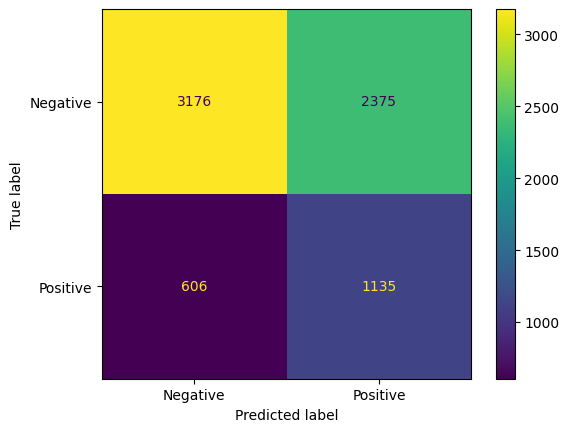

In [ ]:
conf_matrix = confusion_matrix(Y_test.values.ravel(), rf_test_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Negative", "Positive"])
cm_display.plot(values_format='d')
plt.show()

In [ ]:
# ROC AUC score for Random Forest
score_rf = roc_auc_score(Y_test, rf_test_predictions)
score_rf

0.6120366719089896

## 7.3 KNN

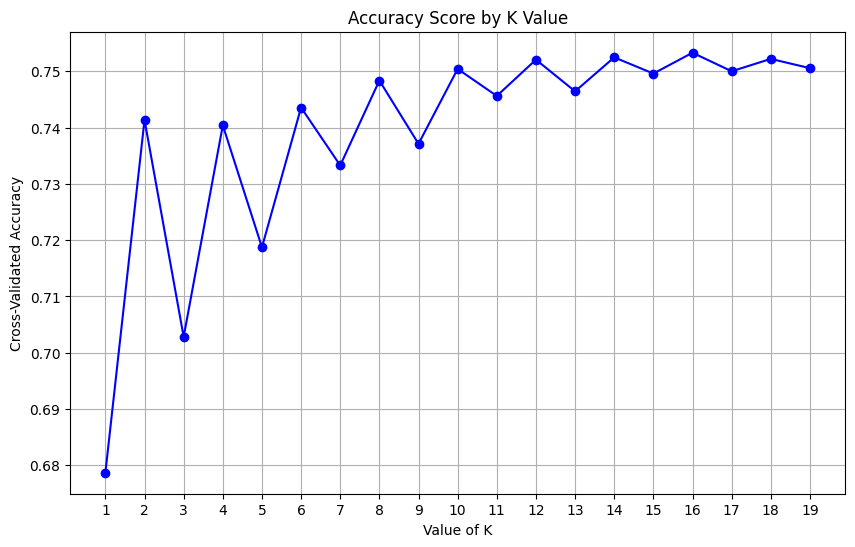

In [ ]:
# Cross Validation
k_values = range(1, 20)
k_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_val, Y_val.values.ravel(), cv=3, scoring='accuracy')
    k_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o', linestyle='-', color='blue')
plt.title('Accuracy Score by K Value')
plt.xlabel('Value of K')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
best_k = 12

In [ ]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_resampled, Y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=12)

In [ ]:
knn_pred = knn.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, knn_pred)
print(f"Accuracy: {accuracy}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(Y_test, knn_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# You can also print a classification report for precision, recall, f1-score for each class
class_report = classification_report(Y_test, knn_pred)
print(f"Classification Report:\n{class_report}")

Accuracy: 0.663878222709819
Confusion Matrix:
[[4035 1516]
 [ 935  806]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      5551
           1       0.35      0.46      0.40      1741

    accuracy                           0.66      7292
   macro avg       0.58      0.59      0.58      7292
weighted avg       0.70      0.66      0.68      7292



In [ ]:
score = roc_auc_score(Y_test, knn_pred)
score

0.5949241905070947

## 7.4 SVM

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale'],
    'kernel': ['rbf', 'poly']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=3, cv=3)

# Fit the model
grid_search.fit(X_train_resampled, Y_train_resampled.values.ravel())

# View the best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.546 total time= 1.7min
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.559 total time= 1.6min


In [ ]:
svm_clf = SVC(kernel='rbf', gamma='scale', C=10, random_state=42)

# Train the model
svm_clf.fit(X_train_resampled, Y_train_resampled.values.ravel())

svm_pred = svm_clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, svm_pred)
print(f"Accuracy of SVM test set: {accuracy}")

Accuracy of SVM test set: 0.5414152495885902


In [ ]:
class_report = classification_report(Y_test, svm_pred)
print(f"Classification Report:\n{class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.53      0.64      5551
           1       0.28      0.57      0.37      1741

    accuracy                           0.54      7292
   macro avg       0.54      0.55      0.51      7292
weighted avg       0.67      0.54      0.58      7292



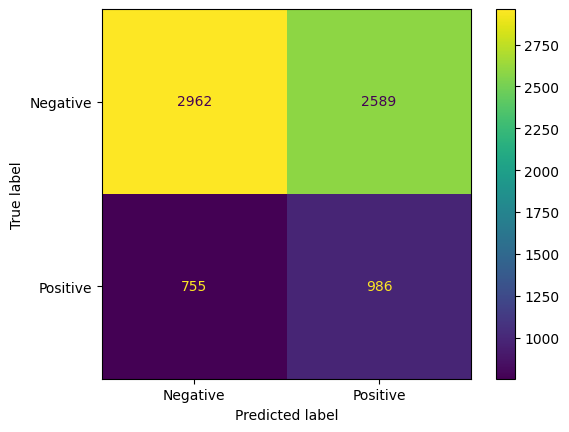

In [ ]:
conf_matrix = confusion_matrix(Y_test.values.ravel(), svm_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Negative", "Positive"])
cm_display.plot(values_format='d')
plt.show()

In [ ]:
score = roc_auc_score(Y_test, svm_pred)
score

0.5499693666095112

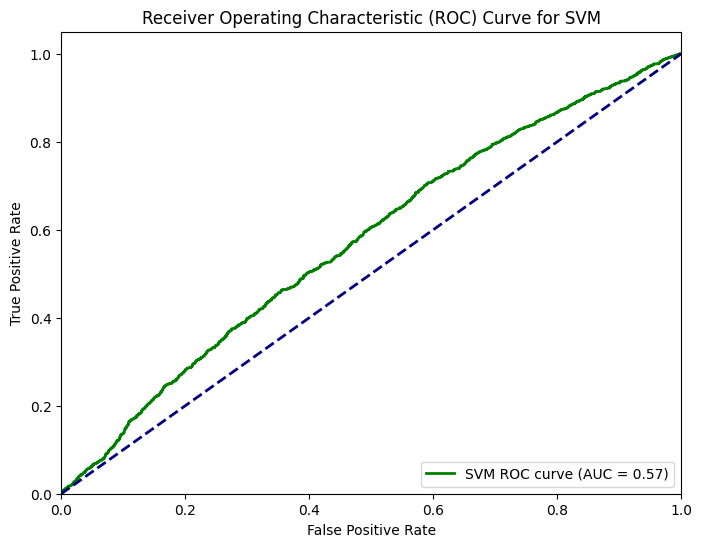

In [ ]:
# Get predicted probabilities for the positive class (class '1')
svm_test_probs = svm_clf.decision_function(X_test)

# Compute ROC curve and AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(Y_test, svm_test_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve for SVM
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'SVM ROC curve (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc='lower right')
plt.show()

## 7.5 Neural Network

In [ ]:
%%capture
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import f1_score

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_resampled, Y_train_resampled, epochs=25, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/25
1043/1043 [==============================] - 4s 3ms/step - loss: 0.6785 - accuracy: 0.5663 - val_loss: 0.6652 - val_accuracy: 0.5845
Epoch 2/25
1043/1043 [==============================] - 2s 2ms/step - loss: 0.6637 - accuracy: 0.5947 - val_loss: 0.7310 - val_accuracy: 0.4425
Epoch 3/25
1043/1043 [==============================] - 2s 2ms/step - loss: 0.6518 - accuracy: 0.6089 - val_loss: 0.6891 - val_accuracy: 0.5328
Epoch 4/25
1043/1043 [==============================] - 2s 2ms/step - loss: 0.6408 - accuracy: 0.6215 - val_loss: 0.6934 - val_accuracy: 0.5163
Epoch 5/25
1043/1043 [==============================] - 3s 3ms/step - loss: 0.6311 - accuracy: 0.6337 - val_loss: 0.6482 - val_accuracy: 0.5974
Epoch 6/25
1043/1043 [==============================] - 4s 3ms/step - loss: 0.6221 - accuracy: 0.6439 - val_loss: 0.6841 - val_accuracy: 0.5632
Epoch 7/25
1043/1043 [==============================] - 3s 3ms/step - loss: 0.6150 - accuracy: 0.6473 - val_loss: 0.7021 - val_accuracy:

In [ ]:
loss, accuracy = model.evaluate(X_train_resampled, Y_train_resampled)
print(f'NN Train Accuracy: {accuracy:.4f}')

loss, accuracy = model.evaluate(X_test, Y_test)
print(f'NN Test Accuracy: {accuracy:.4f}')

1043/1043 [==============================] - 2s 2ms/step - loss: 0.5197 - accuracy: 0.7327
NN Train Accuracy: 0.7327
228/228 [==============================] - 1s 2ms/step - loss: 0.6904 - accuracy: 0.6064
NN Test Accuracy: 0.6064


In [ ]:
# We can tweak the decision threshold
decision_threshold = 0.47
Y_pred = (model.predict(X_test) > decision_threshold).astype("int32")

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(Y_test, Y_pred)
print(f"Classification Report:\n{class_report}")

228/228 [==============================] - 1s 2ms/step
Confusion Matrix:
[[3349 2202]
 [ 781  960]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.60      0.69      5551
           1       0.30      0.55      0.39      1741

    accuracy                           0.59      7292
   macro avg       0.56      0.58      0.54      7292
weighted avg       0.69      0.59      0.62      7292



In [ ]:
score = roc_auc_score(Y_test, Y_pred)
score

0.5773609776444025

## 7.6 Overall ROC Plot

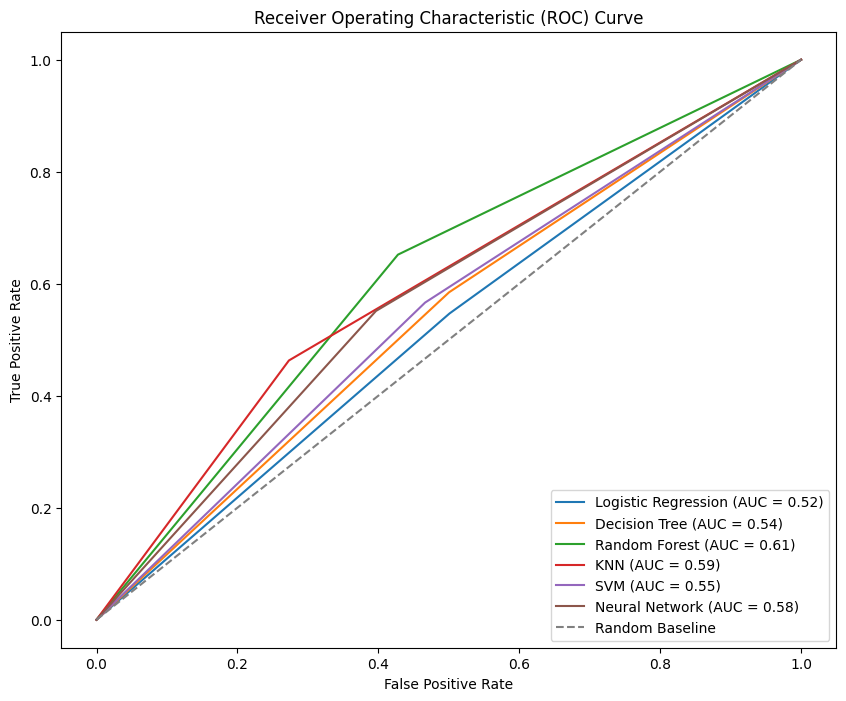

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Logistic Regression
fpr_logistic, tpr_logistic, _ = roc_curve(Y_test, lg_test_predictions)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(Y_test, dt_test_predictions)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(Y_test, rf_test_predictions)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# KNN
fpr_knn, tpr_knn, _ = roc_curve(Y_test, knn_pred)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(Y_test, svm_pred)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Neural Network
fpr_nn, tpr_nn, _ = roc_curve(Y_test, Y_pred)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plotting ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')

# Plotting the random baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Baseline')

# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## 7.7 LIME Analysis

In [ ]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(X_train_resampled.values,
                                              feature_names=X_train_resampled.columns,
                                              class_names=['0', '1'],
                                              discretize_continuous=True)

In [ ]:
# Define prediction functions for different models

def NN_predict_proba(X):
    # Get the model's prediction (probability of class 1)
    pred_probs = model.predict(X)
    # Calculate probabilities for both classes
    return np.hstack((1 - pred_probs, pred_probs))


def knn_predict_proba(X):
    return knn.predict_proba(X)

def lg_predict_proba(X):
    return logistic_model.predict_proba(X)

def rf_predict_proba(X):
    return random_forest.predict_proba(X)

In [ ]:
def lime_analysis(instance_idx, model_function):
    instance = X_test.iloc[instance_idx]
    true_label = Y_test.iloc[instance_idx]


    # Get the explanation using LIME
    explanation = explainer.explain_instance(instance.values,
                                            model_function,
                                            num_features=8, num_samples=1000,labels=[0, 1])

    # Access the predicted probabilities for each class
    lime_predicted_probs = explanation.predict_proba
    print(lime_predicted_probs)

    # Identify the predicted class (index with the highest probability)
    lime_predicted_class = np.argmax(lime_predicted_probs)

    # Print or use the predicted class
    print(f'True Class: {true_label}')
    print(f'LIME Predicted Class: {lime_predicted_class}')

    # Get the LIME coefficients and features
    lime_features_list = explanation.as_list(lime_predicted_class)

    # Sort the features by the absolute value of their coefficients in descending order
    lime_features_list.sort(key=lambda x: abs(x[1]), reverse=True)

    # Separate the features and their coefficients
    features, coefficients = zip(*lime_features_list)

    # Plot the LIME coefficients
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(coefficients)), coefficients, align='center')
    plt.yticks(range(len(coefficients)), features)
    plt.xlabel('Coefficient Value')
    plt.title('LIME Model Coefficients')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest values at the top
    plt.show()

Best vs Worst model

### TP for both models

In [ ]:
instance_idx = 16

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0.166 0.834]
True Class: TARGET    1
Name: 30700, dtype: int64
LIME Predicted Class: 1


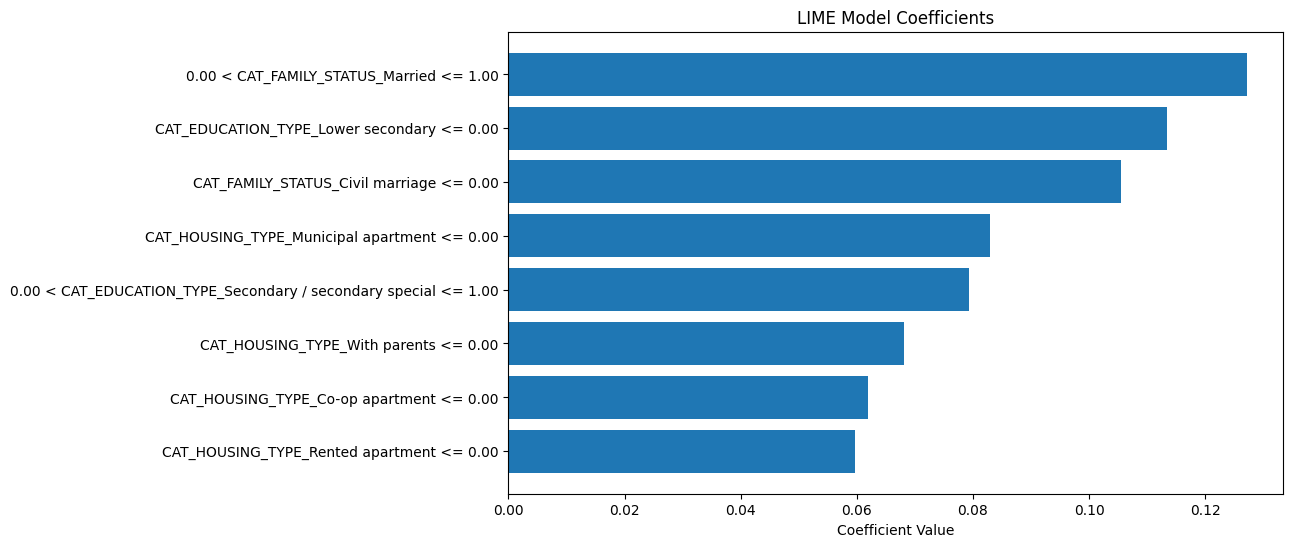

In [ ]:

lime_analysis(instance_idx, rf_predict_proba)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


[0.47573957 0.52426043]
True Class: TARGET    1
Name: 30700, dtype: int64
LIME Predicted Class: 1


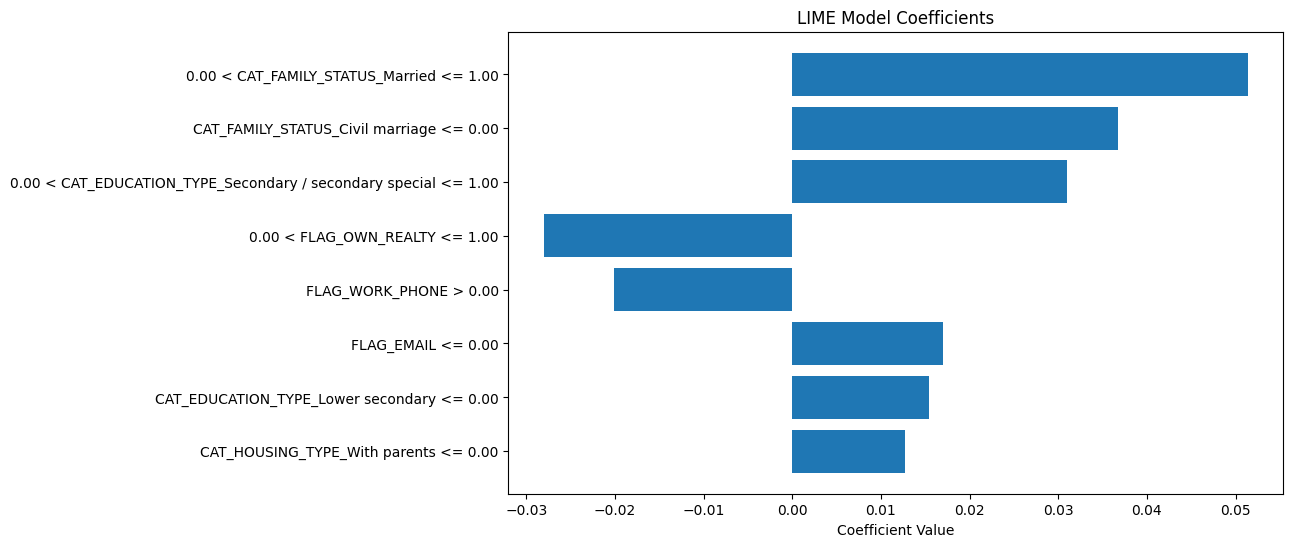

In [ ]:

lime_analysis(instance_idx, lg_predict_proba)

### TP for best model, FN for worst model

In [ ]:
instance_idx = 52

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0.18416667 0.81583333]
True Class: TARGET    1
Name: 22607, dtype: int64
LIME Predicted Class: 1


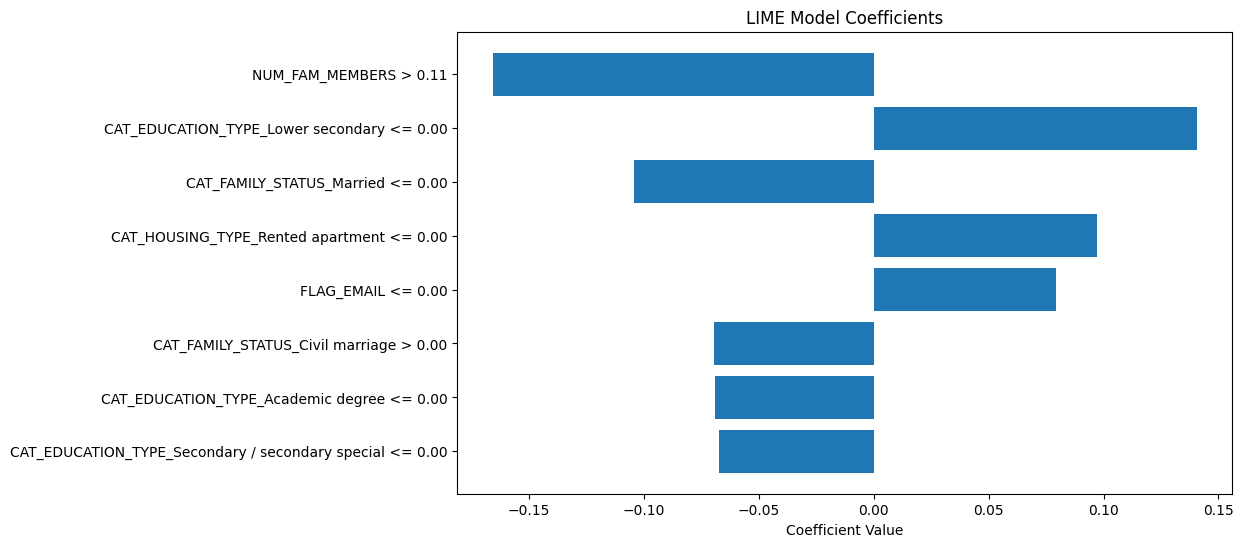

In [ ]:
lime_analysis(instance_idx, rf_predict_proba)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


[0.5689118 0.4310882]
True Class: TARGET    1
Name: 22607, dtype: int64
LIME Predicted Class: 0


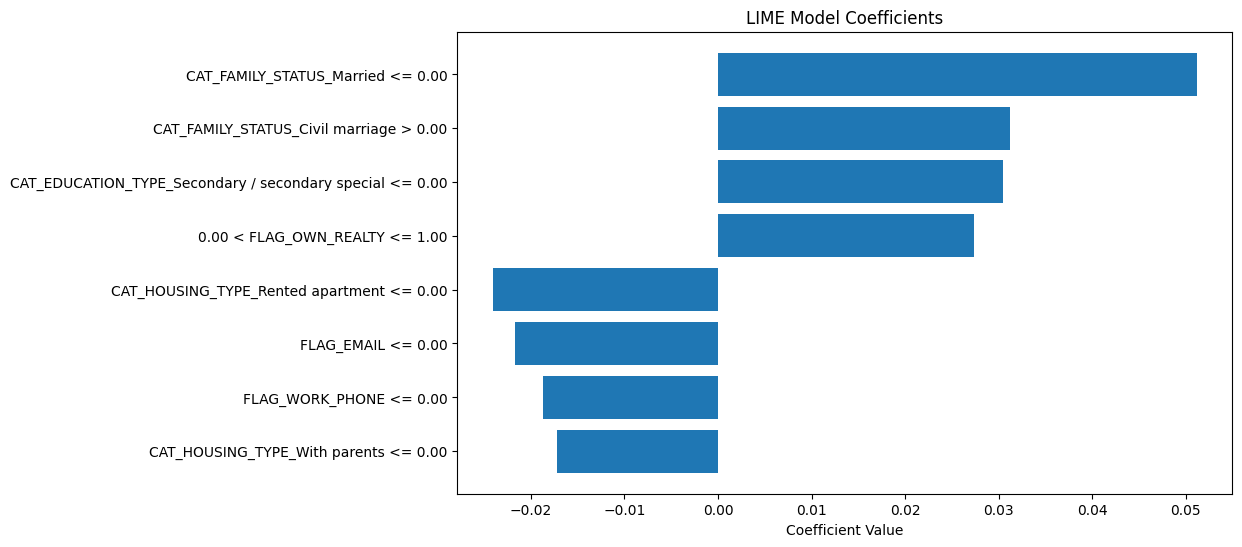

In [ ]:
lime_analysis(instance_idx, lg_predict_proba)